# New York City Taxi Trip Duration

## Problem Statement

### Overview
This is a kaggle competition that challenges us to predict the taxi trip duration in New York city. Dataset is provided by the NYC taxi and Limousine commision for building a model.

Money prize: 30,000$.

Business motivation: providing good driving time estimation to
- Detect bottlenecks that appear in the taxi traffic network.
- Predict the taxi trip price. 

Input: a taxi trip with it's attributes. \
Output: trip duration in seconds. 
 
### Input and Output Data description

There are three files:
- train.csv: (1458644,11)
- test.csv: (625134,9)
- sample_submission.csv: (625134,2) 

| Column name | Description | 
| -------- | -------- | 
| id   | the id for each trip     |
| vendor_id   | the id provided Associated with the trip record     |
| pickup_datetime   | date and time when the meter was engaged     |
| dropoff_datetime   | date and time when the meter was disengaged    |
| passenger_count   | The number of passengers in the taxi    |
| pickup_longitude   | the longitude when the meter was engaged     |
| pickup_latitude   | the latitude when the meter was engaged   |
| dropoff_longitude   | the longitude when the meter was disengaged     |
| dropoff_latitude   | the latitude when the meter was disengaged     |
| store_and_fwd_flag   | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server  |
| trip_duration  | duration of the trip in seconds     |


- A record in train.csv

![](https://i.imgur.com/LtLFbTO.png)

- A record in test.csv
![](https://i.imgur.com/gEJR1jT.png)

- A record in sample_submission.csv
![](https://i.imgur.com/zwq0ezw.png)




### Evaluation Metric
- **Root Mean Squared Logarithmic Error** (RMSLE) is the metric was used to assess the result of this contest.

$$\epsilon = \sqrt{\frac{1}{n}\sum^{n}_{i=1}(log(p_i + 1) -log(a_i + 1)) ^2}$$

* With respect to:
    * $\epsilon$: RMSLE score
    * n: the number of records (trip duration's observations) in the dataset
    * $p_i$: the prediction of trip duration
    * $a_i$: the actual value of trip duration
    * log(x): natural logarithm (base is e)

* **The smaller the RMSLE value is, the better the model**.

In [1]:
# Crafting good features for XGBoost 

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
!unzip ../input/nyc-taxi-trip-duration/train.zip -d nyc-taxi-trip-duration
!unzip ../input/nyc-taxi-trip-duration/test.zip -d nyc-taxi-trip-duration
!unzip ../input/nyc-taxi-trip-duration/sample_submission.zip -d nyc-taxi-trip-duration

Archive:  ../input/nyc-taxi-trip-duration/train.zip
  inflating: nyc-taxi-trip-duration/train.csv  
Archive:  ../input/nyc-taxi-trip-duration/test.zip
  inflating: nyc-taxi-trip-duration/test.csv  
Archive:  ../input/nyc-taxi-trip-duration/sample_submission.zip
  inflating: nyc-taxi-trip-duration/sample_submission.csv  


In [3]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('./nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('./nyc-taxi-trip-duration/test.csv')
sample_submission = pd.read_csv('./nyc-taxi-trip-duration/sample_submission.csv')

In [4]:
def check_basic(df, df_type="train"):
    print("{} DF has {} rows and {} columns".format(df_type,df.shape[0], df.shape[1]))
    if df.id.nunique() == df.shape[0]:
        print("1. Id is unique")
    if not df.isnull().any().any(): 
        print("2. No missing value")
  
def check_consistent():
    pass

In [5]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [6]:
check_basic(train, df_type="train")

train DF has 1458644 rows and 11 columns
1. Id is unique
2. No missing value


In [7]:
test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N


In [8]:
check_basic(test, df_type="test")

test DF has 625134 rows and 9 columns
1. Id is unique
2. No missing value


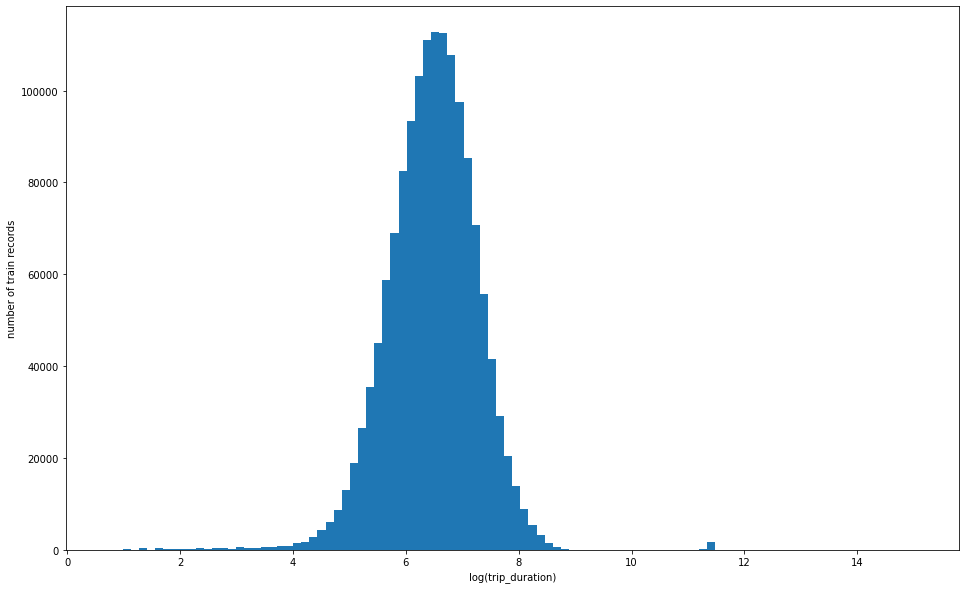

In [9]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [10]:
# Check time_duration = time_drop - time_pick